In [1]:
import pylab
import h5py
import math
import array
from numpy import *
import numpy as np
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.waveform.waveform_modes import get_td_waveform_modes
from pycbc import types, fft, waveform
import lal
from scipy import interpolate
from scipy.interpolate import interp1d
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI, PI
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from tqdm import tqdm#

#from matplotlib import rcParams
#rcParams.update({'figure.autolayout': True})
import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 200
#plt.rcParams["font.family"] = "monospace"
 
from matplotlib import gridspec
from matplotlib import ticker

import matplotlib.pyplot as plt
#plt.style.reload_library()
#plt.style.use(['science','notebook'])



#pylab.rc('xtick', labelsize=18) 
#pylab.rc('ytick', labelsize=18) 
#pylab.rc('axes', labelsize=16)
#pylab.rc('legend', fontsize=15)


# Eccentricity $e (\xi_{\phi})$

In [2]:
# Eq. (4.17a, 4.17b), Pg. 18, Moore et al (2016)

def epsilon(xi, eta):
    return(( 1 + ( ( -2833/2016 + 197/72 * eta ) * ( xi )**( 2/3 ) + 
                  ( -377/144 * np.pi * xi + ( ( 77006005/24385536 + ( -1143767/145152 * eta + 
 	 43807/10368 * ( eta )**( 2 ) ) ) * ( xi )**( 4/3 ) + ( np.pi * ( 9901567/1451520 + 
 	 -202589/362880 * eta ) * ( xi )**( 5/3 ) + ( xi )**( 2 ) * ( -33320661414619/386266890240 + 
 	 ( 3317/252 * EulerGamma + ( 180721/41472 * ( np.pi )**( 2 ) + ( ( 161339510737/8778792960 + 
 	 3977/2304 * ( np.pi )**( 2 ) ) * eta + ( -359037739/20901888 * ( eta )**( 2 ) + 
      ( 10647791/2239488 * ( eta )**( 3 ) + ( -87419/3780 * np.log( 2 ) + 
 	 ( 26001/1120 * np.log( 3 ) + 3317/504 * np.log( 16 * ( xi )**( 2/3 ) ) ) ) ) ) ) ) ) ) ) ) ) ) ))

# Fit Files

In [3]:
# "Hinder+ modified all 20 simulations SEOBNRv4 model, full frequency range --Feb 16
g=open('tshift_H+modified_20hyb_Feb16.txt',"r") 
lines=g.readlines() 
A=[] 
for x in lines: 
    A.append(float(x.split()[1])) 
g.close()

def tshift_Hinsp(q,e,l): 
    return A[0] + A[1]*q + A[2]*q**2 + A[3]*e + A[4]*e**2 + A[5]*e**3 + A[6]*e*q + A[7]*(e**2)*q + A[8]*e*(q**2) + A[9]*(e**2)*(q**2) + A[10]*(e**3)*q + A[11]*e*q*math.cos(l + A[12]) + A[13]*(e**2)*(q**2)*math.cos(e*l + A[14]) + A[15]*(e**3)*q*math.cos(l + A[16]) + A[17]*e*(q**2)*math.cos(l + A[18])

g=open('tamp_H+modified_20hyb_Feb16.txt',"r") 
lines=g.readlines() 
B=[] 
for x in lines: 
    B.append(float(x.split()[1])) 
g.close()

def tamp_Hinsp(eta,e,l): 
    return B[0] + B[1]*eta + B[2]*eta**2 + B[3]*e + B[4]*e**2 + B[5]*e**3 + B[6]*e*eta + B[7]*(e**2)*eta + B[8]*e*(eta**2) + B[9]*(e**2)*(eta**2) + B[10]*(e**3)*eta + B[11]*e*eta*math.cos(l + B[12]) + B[13]*(e**2)*(eta**2)*math.cos(l + B[14]) + B[15]*(e**3)*eta*math.cos(e*l + B[16])

g=open('tfreq_H+modified_20hyb_Feb16.txt',"r") 
lines=g.readlines() 
C=[] 
for x in lines: 
    C.append(float(x.split()[1])) 
g.close()

def tfreq_Hinsp(eta,e,l): 
    return C[0] + C[1]*eta + C[2]*eta**2 + C[3]*e + C[4]*e**2 + C[5]*e**3 + C[6]*e*eta + C[7]*(e**2)*eta + C[8]*e*(eta**2) + C[9]*(e**2)*(eta**2) + C[10]*(e**3)*eta + C[11]*e*eta*math.cos(l + C[12]) + C[13]*(e**2)*(eta**2)*math.cos(l + C[14]) + C[15]*(e**3)*eta*math.cos(e*l + C[16])+ C[17]*(e**3)*(eta**2)*math.cos(e*l + C[18])

# Spherical Harmonics

In [4]:
def sph_harmonics(inc,ell):
    L=ell
    #inc = 10
    theta = inc
    for l in range(L,L+1):

        for m in range(-l,l+1):
            dlm = 0;
            k1 = max([0, m-2]);
            k2 = min([l+m, l-2]);

            #if(m==l or m==l-1):
            for k in range(k1,k2+1):
                A = []; B = []; cosTerm = []; sinTerm = []; dlmTmp = [];

                A = (-1)**k*math.sqrt(math.factorial(l+m)*math.factorial(l-m)*math.factorial(l+2)*math.factorial(l-2));
                B = math.factorial(k)*math.factorial(k-m+2)*math.factorial(l+m-k)*math.factorial(l-k-2);

                cosTerm = pow(math.cos(theta/2), 2*l+m-2*k-2);
                sinTerm = pow(math.sin(theta/2), 2*k-m+2);

                dlmTmp = (A/B)*cosTerm*sinTerm;
                dlm = dlm+dlmTmp

            Ylm = math.sqrt((2*l+1)/(4*math.pi))*dlm
            #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
            if m==ell:
                #globals()['sph' + str(l) + str(m)] = Ylm
                #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
                sphlm = Ylm
            elif m==-ell:
                #globals()['sph' + str(l) + '_' + str(abs(m))] = Ylm
                #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
                sphl_m = Ylm
            else:
                continue
    return sphlm, sphl_m

In [5]:
def xi(x):
    return x**(3/2)

def xconv(f,M):
    return (PI*M*MTSUN_SI*f)**(2/3)  #22 mode conversion

def fconv(x,M):
    return x**(3/2)/(PI*M*MTSUN_SI)  #22 mode conversion



# MODEL $(l,m) = (2,2)$ (Using EccentricTD)

In [6]:
def MODEL22(m,q0,e0,l0,fmin,angle,d,delta_t):
    
    #m=Total mass, q0= mass ratio, e0=initial orbital ecc, l0=mean anomaly, fmin= initial frequency,
    #angle= inclination, d= distance in Mpc, delta_t=sampling rate
    
    mode2polfac=4*(5/(64*np.pi))**(1/2)
    M=m
    M1=q0*M/(1+q0)
    M2=M/(1+q0)
    eta=q0/(1+q0)**2
    M_SI=M*MSUN_SI
    D_SI=(10**(6))*PC_SI
    
    hp, hc = get_td_waveform(approximant='EccentricTD', mass1=M1, mass2=M2, delta_t=delta_t,f_lower=fmin, eccentricity=e0)
    sp, sc = get_td_waveform(approximant='SEOBNRv4', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin)
    
    tshift = -tshift_Hinsp(q0,e0,l0)*M*MTSUN_SI
    tmin = max(hp.sample_times[0]-tshift,sp.sample_times[0])
    
    # CIRCULAR IMR INTERP1D
    sp_intrp = interp1d(sp.sample_times,sp, kind='cubic',fill_value='extrapolate')
    sc_intrp = interp1d(sc.sample_times,sc, kind='cubic',fill_value='extrapolate')
    tImr_intrp=np.arange(tmin, sp.sample_times[-1], delta_t)
    sp_intrp=sp_intrp(tImr_intrp)
    sc_intrp=sc_intrp(tImr_intrp)
    tImr = tImr_intrp
    hpImr = sp_intrp
    hcImr = sc_intrp
    h22Imr=hpImr+1j*hcImr
    
    # ECCTD INTERP1D
    hp_intrp=interp1d(hp.sample_times-tshift, hp, kind='cubic',fill_value='extrapolate')
    hc_intrp=interp1d(hc.sample_times-tshift, hc, kind='cubic',fill_value='extrapolate')
    
    tEcc_intrp=np.arange(tmin,hp.sample_times[-1]-tshift, delta_t) #Need to know ????
    hp_intrp=hp_intrp(tEcc_intrp)
    hc_intrp=hc_intrp(tEcc_intrp)
    tEcc=tEcc_intrp
    hpEcc=hp_intrp
    hcEcc=hc_intrp
    h22Ecc=hpEcc+1j*hcEcc
    
    #Matching initial phase
    phaseEcc=np.unwrap(np.angle(h22Ecc)*2)/2
    phaseImr = np.unwrap(np.angle(h22Imr)*2)/2
    dphase = phaseEcc[0]-phaseImr[0]
    hp_new=real(h22Ecc*exp(-1j*dphase))
    hc_new=imag(h22Ecc*exp(-1j*dphase))
    
    phase_new=np.unwrap(np.angle(hp_new+1j*hc_new)*2)/2
    phaseEcc=phase_new
    h22Ecc_new=hp_new+1j*hc_new
    
    arg=np.argmin(abs(tEcc-tamp_Hinsp(eta,e0,l0)*M*MTSUN_SI)) 
    Idxjoin=arg
    
    t_amp=tEcc[Idxjoin] - 500*M*MTSUN_SI
    idxstr=np.argmin(abs(tEcc-t_amp)) 
    
    #Amplitude model
    amp=[]
    count=0
    length=Idxjoin-idxstr
    
    for i in range(idxstr,Idxjoin):
        amp.append(((length-count)*abs(h22Ecc_new[i])+count*abs(h22Imr[i]))/length) #EDIT
        count=count+1
        
    t_model=np.concatenate((tEcc[0:Idxjoin],tImr[Idxjoin:len(tImr)]))
    h22amp=np.concatenate((abs(h22Ecc_new[0:idxstr]),amp)) #EDIT
    h22amp_model=np.concatenate((h22amp,abs(h22Imr[Idxjoin:len(h22Imr)])))
    
    omegaEcc=(M*MTSUN_SI/delta_t)*(np.gradient(phaseEcc))
    omegaImr=(M*MTSUN_SI/delta_t)*(np.gradient(phaseImr))
    
    tjoin0=tfreq_Hinsp(eta,e0,l0)
    tjoin=tjoin0*M*MTSUN_SI
    fjoin=np.argmin(abs(tEcc-tjoin))
    
    #Frequency model
    tstop = min(tEcc[-1],-30*M*MTSUN_SI)
    lst = np.argmin(abs(tEcc-tstop))

    indx = lst - fjoin
    a0 = []
    n = indx - 1 
    k = 0
    for i in range(fjoin,fjoin+indx):   
        a0.append(((n-k)*omegaEcc[i]+k*omegaImr[i])/n)
        k = k+1

    f1 = np.concatenate((omegaEcc[0:fjoin],a0))
    frequency_model = np.concatenate((f1,omegaImr[fjoin+indx:len(omegaImr)]))
    phase_f_model = np.cumsum(frequency_model)/(M*MTSUN_SI/delta_t) + PI/1.4#PI/2.1#PI/0.1#


    hp_f_model = h22amp_model * np.cos(phase_f_model)
    hc_f_model = h22amp_model * np.sin(phase_f_model)
    
    print('Inclination = ',angle,' degrees')
    
    #Plot
    plt.figure(figsize=(10,4.8))
    plt.plot(t_model/(M*MTSUN_SI), h22amp_model/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac), color='saddlebrown',alpha=1,linestyle='--',dashes=(4.5,3),linewidth=3,label='Model_22',zorder=3)
    plt.plot(tEcc/(M*MTSUN_SI),abs(h22Ecc_new)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),linestyle='-',linewidth=2.5,color='springgreen',alpha=0.8,label='EccentricTD',zorder=2)
    plt.plot(tImr/(M*MTSUN_SI),abs(h22Imr)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),linestyle='-',linewidth=2.5,color='dodgerblue',alpha=0.8,label='SEOBNRv4',zorder=2)
    plt.xlim(xmin=-1200)
    plt.xlim(xmax=100)
    plt.ylim(ymax=4.5e-1)
    plt.ylim(ymin=3e-2)
    plt.ylabel(r'$\mathcal{A}_{22}$',fontsize=22,labelpad=5)
    plt.xlabel(r'$t/M$',fontsize=22)
    plt.yscale('log')
    plt.legend()
    
    plt.figure(figsize=(10,4.8))
    plt.plot(t_model/(M*MTSUN_SI), frequency_model, color='saddlebrown',alpha=1,linestyle='--',dashes=(4.5,3),linewidth=3,label='Model_22',zorder=3)
    plt.plot(tEcc/(M*MTSUN_SI),omegaEcc,linestyle='-',linewidth=2.5,color='springgreen',alpha=0.8,label='EccentricTD',zorder=2)
    plt.plot(tImr/(M*MTSUN_SI),omegaImr,linestyle='-',linewidth=2.5,color='dodgerblue',alpha=0.8,label='SEOBNRv4',zorder=2)
    plt.xlim(xmin=-4500)
    plt.xlim(xmax=100)
    plt.ylim(ymin=2.5e-2)
    plt.ylim(ymax=3e-1)
    plt.ylabel(r'$M\omega_{22}$',fontsize=22,labelpad=5)
    plt.xlabel(r'$t/M$',fontsize=22)
    plt.yscale('log')
    plt.legend()

Inclination =  0  degrees


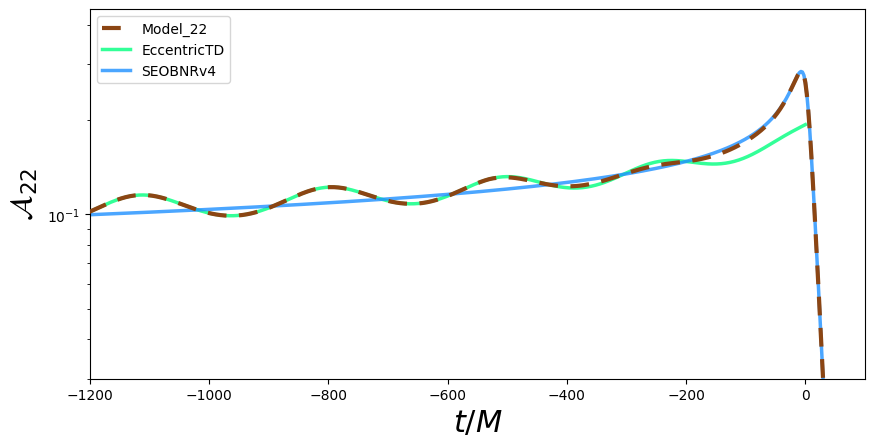

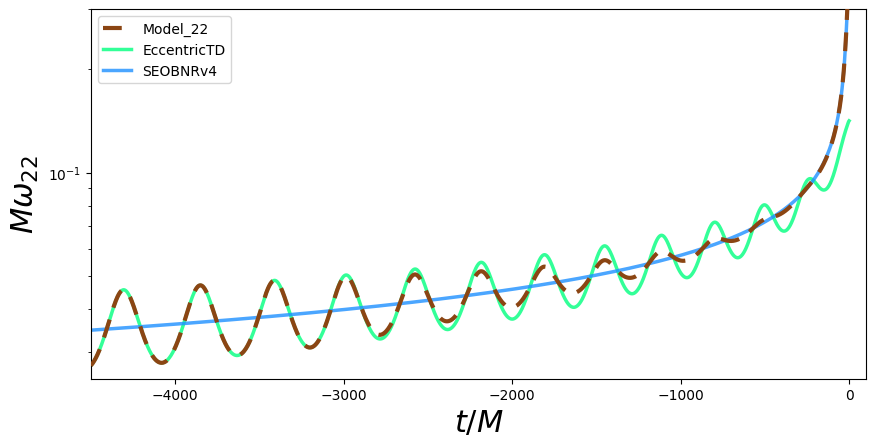

In [7]:
#MODEL22(40,3,0.142,0.665,20,0,1,1./2048)

# EccentricTD Parameters

In [8]:
def PNparams(M,q,d,f_low,e0,delta_t):
    M2=M/(1+q)
    M1=M2*q
    hpVec_PN, hcVec_PN = get_td_waveform(approximant='EccentricTD', mass1=M1, mass2=M2, 
                             delta_t=delta_t, 
                             f_lower=f_low, 
                             eccentricity=e0,
                             distance=d)
    
    modetopolfac=4*(5/(64*np.pi))**(1/2)  #conversion factor between mode amplitude and strain amplitude
                                          # check 0704.3764 equation 7 for details
    M_SI = M * MSUN_SI
    D_SI = 10**6 * PC_SI * d
    phase_EccTD = waveform.utils.phase_from_polarizations(hpVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)), hcVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)))
    tVec_PN=hpVec_PN.sample_times/(M*MTSUN_SI)
    
    return phase_EccTD, tVec_PN

# MODEL $(l,m)=(2,2)$ (Using Ebersold Amplitudes)

In [33]:
def INSP_Eber(lp,mp,inc):
    mp=mp
    q=2
    eref=0.05
    e0=0.12
    eta=neu=nu=q/(1+q)**2
    xlow=0.045
    xref=0.075
    cl=lref=2.132
    G=c=d=1
    M=1
    M_SI=M*MSUN_SI
    D_SI=(10**(6))*PC_SI
    M2=M/(1+q)
    M1=M2*q
    Delta=math.sqrt(1-(4*neu))
    gamma=EulerGamma=0.577215664901
    %run GW_functions.ipynb
    mt=M
    m_sun=MSUN_SI
    conv=mt*MTSUN_SI
    
    def freq(u,mass):
        return math.pow(u,3.0/2.0)/(2*MTSUN_SI*mass*lal.PI/2)
    
    f_low=freq(xlow,mt)
    f_ref=freq(xref,mt)
    x=xlow
    v=math.sqrt(x)
    vref=math.sqrt(xref)
    xie=v**3
    xiref=vref**3
    e=eref*(xiref/xie)**(19/18)*epsilon(xie, eta)/epsilon(xiref, eta)

    
    hpVec_PN, hcVec_PN=get_td_waveform(approximant='EccentricTD',mass1=M1,
                                      mass2=M2,delta_t=1/2**20,f_lower=f_low,
                                      eccentricity=e0,distance=1)
    
    #inspired from PN-NR comp.ipynb
    tC_NR=0.01689910888671875
    tVec_PN_shifted=tC_NR+hpVec_PN.sample_times
    phase_EccTD = waveform.utils.phase_from_polarizations(hpVec_PN/((G_SI*M_SI/D_SI/C_SI/C_SI)), hcVec_PN/((G_SI*M_SI/D_SI/C_SI/C_SI)))

   
    tVec_PN_GM=tVec_PN_shifted/conv
    hpVec_PN_GM=hpVec_PN/((G_SI*M_SI/D_SI/C_SI/C_SI))
    hcVec_PN_GM=hcVec_PN/((G_SI*M_SI/D_SI/C_SI/C_SI))
    tC_NR=tC_NR/conv
    
    tVec_PN=tVec_PN_GM
    tC_NR=tC_NR
    
    xi_ref=xref**(3/2)
    x0=xlow
    xi0=x0**(3/2)
    v0=xi0**(1/3)
    l0=mean_anomaly(xi_ref,xi0,lref,eta,e0)
    theta=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN)**(-1/8)
    theta0=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN[0])**(-1/8)
    fVec=x_from_t(theta, theta0, e0, M, eta)
    
    xiVec=(np.pi*M*fVec)
    xVec=xiVec**(2/3)
    vVec=xiVec**(1/3)
    
    for i in range(0,len(xVec)):
        if xVec[i]>=0.1025:
            #print(i)
            break
    lst=100104
    
    plotIdx2=np.nonzero(fVec>=0)
    fVec=fVec[plotIdx2]
    xiVec=xiVec[plotIdx2]
    xVec=xVec[plotIdx2]
    vVec=vVec[plotIdx2]
    maxPNidx=len(xVec)
    
    j=0
    omega=[]
    phasePN = []
    hlm_real=[]
    hlm_imag=[]
    hlm_abs22=[]
    h22=[]
    h2_2=[]
    
    for i in tqdm(xVec):
        v=math.sqrt(i)
        v0=math.sqrt(x0)
        xie=v**3
        xi0=v0**3
        e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
        l=mean_anomaly(xie, xi0, l0, eta,e0)
        psi=phase_EccTD[j]
        j=j+1
        xi=l   #use xi for amplitude (xie is being used for v**3)
        x=i
        h=amplitude_22(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
        phasePN.append(mp*psi/2)
        hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
        hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        #hlm_real.append(hlm.real)
        #hlm_imag.append(hlm.imag)
        #hlm_abs33.append(abs(hlm))
        h22.append(hlm)
        h2_2.append(hl_m)
        
    sph22, sph2_2 = sph_harmonics(inc,lp)
    
    h = np.multiply(h22,sph22)+np.multiply(h2_2,sph2_2)
    hp=np.real(h)
    hc=np.imag(h)
    H=hp+1j*hc
    H=abs(H) 
    tPN=tVec_PN[:maxPNidx]
    PNamp=H[:maxPNidx]
    lst = 100050
    #plt.ylim(ymax=1e0)
    #plt.ylim(ymin=2e-5)
    #plt.xlim(xmin=-3350)
    #plt.xlim(xmax=450)
    #plt.yscale('log')
    #plt.plot(tPN[:lst]-tPN[np.argmax(PNamp)] + 32,PNamp[:lst],linewidth = 1,color='black',linestyle='-')
    return tPN[:lst]-tPN[np.argmax(PNamp)] + 32,PNamp[:lst]

In [34]:
def MODEL22(angle):
    hfile = ['1364hyb_EccTD_xlow045_GM.h5'] #Hybrid
    l0= -0.181 #0.665
    x0=0.045
    e0=0.120 #0.142
    q=2 #3
    eta=q/(1+q)**2
    f0=20
    
    for i in range(0,len(hfile)):
        hyb_name=hfile[i][0:4]
        f=h5py.File(hfile[i],'r')
        data=f['l2_m2']
        tVec=real(data[0:,0])
        h22pVec=real(data[0:,1])
        h22cVec=real(data[0:,2])
        mode2polfac=4*(5/(64*np.pi))**(1/2)
        hpVec=h22pVec
        hcVec=h22cVec
        
        tVec=tVec - tVec[np.argmax(abs(hpVec+1j*hcVec))]
        M=40
        M1=q*M/(1+q)
        M2=M/(1+q)
        q0=q
        M_SI=M*MSUN_SI
        D_SI=(10**(6))*PC_SI
        tVec=tVec*M*MTSUN_SI
        hpVec=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac
        hcVec=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac
        
        tVec = tVec - tVec[np.argmax(abs(hpVec+1j*hcVec))]
        
        delta_t = delta_t_NR = np.abs(np.mean((np.diff(tVec))))
        
        fref = 0.075**(3/2) /MTSUN_SI/ PI/M
        fmin = 0.045**(3/2) /MTSUN_SI/ PI/M
        
        tEber, h22Eber = INSP_Eber(2,2,angle)
        
        sp,sc = get_td_waveform(approximant='SEOBNRv4HM', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin, inclination=angle, mode_array=[[2,2]])
        
        
        tEber=np.array(tEber)*(M*MTSUN_SI)
        #tEber=list(tEber)
        h22Eber=np.array(h22Eber)*(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac)
        #h22Eber=list(h22Eber)
        
        tshift = -tshift_Hinsp(q0,e0,l0)*M*MTSUN_SI
        tmin = max(tEber[0]-tshift, sp.sample_times[0])
        
        #Circular IMR
        sp_intrp = interp1d(sp.sample_times, sp, kind='cubic', fill_value='extrapolate')
        sc_intrp = interp1d(sc.sample_times, sc, kind='cubic', fill_value='extrapolate')
        tImr_intrp = np.arange(tmin, sp.sample_times[-1], delta_t)
        sp_intrp = sp_intrp(tImr_intrp)
        sc_intrp = sc_intrp(tImr_intrp)
        tImr = tImr_intrp
        hpImr = sp_intrp
        hcImr = sc_intrp
        h22Imr = hpImr + 1j*hcImr
        
        tshift = -tshift_Hinsp(q0,e0,l0)*M*MTSUN_SI
        
        #Interpolation Ebersold
        h22Eber_intrp = interp1d(tEber-tshift, h22Eber, kind='cubic', fill_value = 'extrapolate')
        tEber_intrp = np.arange(tmin, tEber[-1]-tshift, delta_t)
        h22Eber_intrp=h22Eber_intrp(tEber_intrp)
        arg = np.argmin(abs(tEber_intrp-tamp_Hinsp(eta,e0,l0)*M*MTSUN_SI))
        Idxjoin = arg
        
        t_amp = tamp_Hinsp(eta,e0,l0) - 500
        idxstr = np.argmin(abs(tEber_intrp-t_amp*M*MTSUN_SI))
        
        #Amplitude Model
        amp=[]
        count=0
        length=Idxjoin-idxstr
        
        for i in range(idxstr,Idxjoin):
            amp.append(((length-count)*h22Eber_intrp[i]+count*abs(h22Imr[i]))/length)
            count=count+1
            
        t_model=np.concatenate((tEber_intrp[0:Idxjoin],tImr[Idxjoin:len(tImr)]))
        h22amp=np.concatenate((abs(h22Eber_intrp[0:idxstr]),amp))
        h22amp_model=np.concatenate((h22amp,abs(h22Imr[Idxjoin:len(h22Imr)])))
        
        print('Mode = (2,2) , Inclination = ',angle,' degrees')
        #Plot
        plt.figure(figsize=(10,4.8))
        plt.plot(t_model/(M*MTSUN_SI),h22amp_model/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac), color = 'saddlebrown',alpha=1,dashes=(4.5,3),linewidth=3,linestyle='--',label='Model_22',zorder=3)
        plt.plot(tEber/(M*MTSUN_SI),h22Eber/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),linestyle='-',linewidth=2.5,color='springgreen',alpha=0.8,label='Ebersold',zorder=2)
        plt.plot(tImr/(M*MTSUN_SI),abs(h22Imr)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),linestyle='-',linewidth=2.5,color='dodgerblue',alpha=0.8,label='SEOBNRv4HM',zorder=2)
        
        plt.ylim(ymax=1e0)
        plt.ylim(ymin=2e-5)
        plt.xlim(xmin=-3350)
        plt.xlim(xmax=450)
        plt.ylabel(r'$\mathcal{A}_{22}$',fontsize=22,labelpad=5)
        plt.xlabel(r'$t/M$',fontsize=22)
        plt.yscale('log')
        plt.legend()
        
        
        

100%|█████████████████████████████████| 100106/100106 [01:26<00:00, 1157.35it/s]


Mode = (2,2) , Inclination =  10  degrees


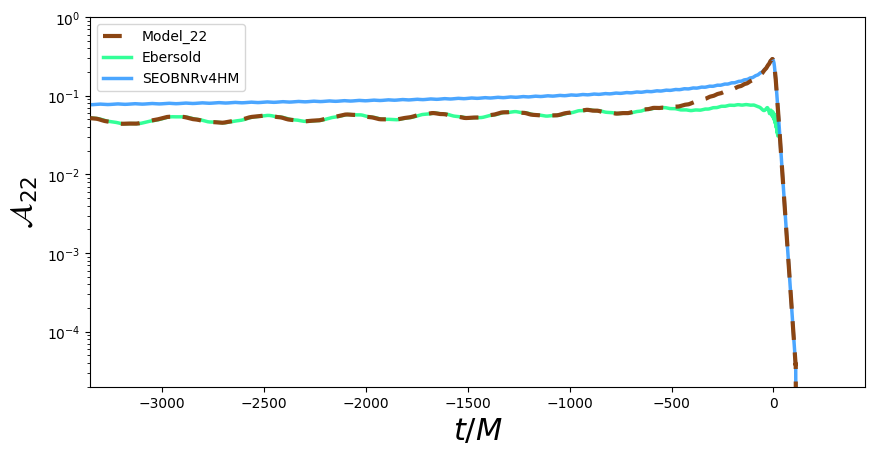

100%|█████████████████████████████████| 100106/100106 [01:25<00:00, 1168.24it/s]


Mode = (2,2) , Inclination =  20  degrees


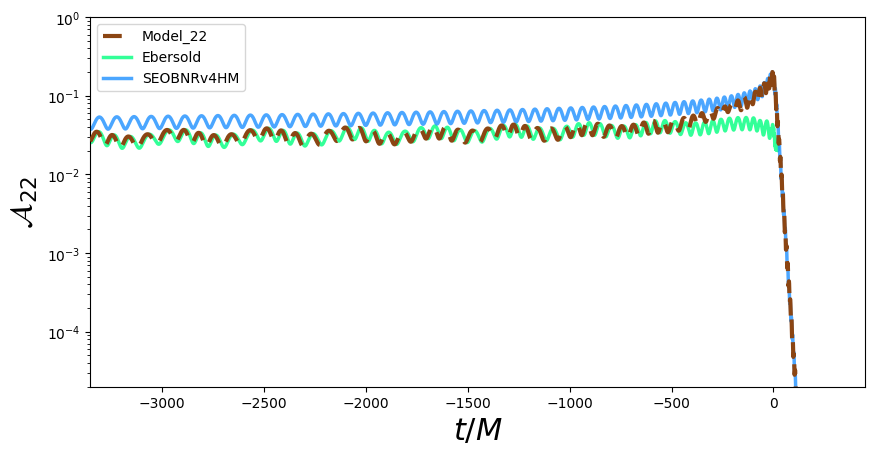

100%|█████████████████████████████████| 100106/100106 [01:30<00:00, 1105.00it/s]


Mode = (2,2) , Inclination =  30  degrees


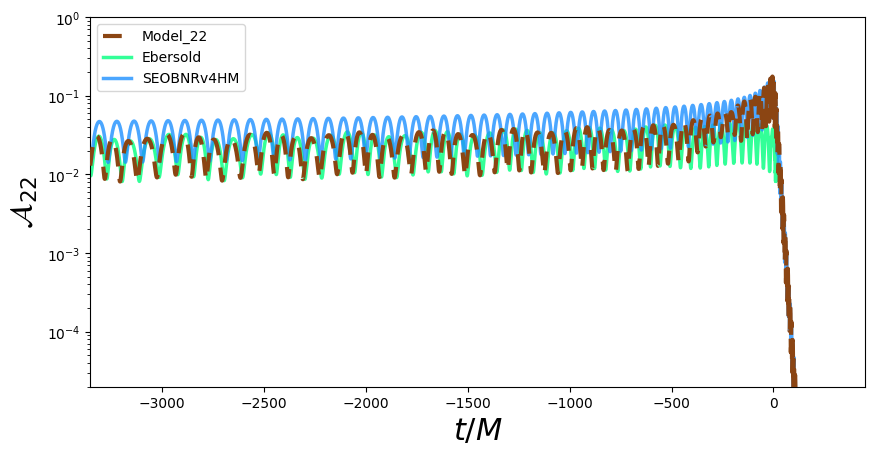

In [35]:
#MODEL22(10)
#MODEL22(20)
#MODEL22(30)

# MODEL $(l,m)=(3,3)$

In [14]:
def INSP_Eber(lp,mp,inc):
    mp=mp
    q=2
    eref=0.05
    e0=0.12
    eta=neu=nu=q/(1+q)**2
    xlow=0.045
    xref=0.075
    cl=lref=2.132
    G=c=d=1
    M=1
    M_SI=M*MSUN_SI
    D_SI=(10**(6))*PC_SI
    M2=M/(1+q)
    M1=M2*q
    Delta=math.sqrt(1-(4*neu))
    gamma=EulerGamma=0.577215664901
    %run GW_functions.ipynb
    mt=M
    m_sun=MSUN_SI
    conv=mt*MTSUN_SI
    
    def freq(u,mass):
        return math.pow(u,3.0/2.0)/(2*MTSUN_SI*mass*lal.PI/2)
    
    f_low=freq(xlow,mt)
    f_ref=freq(xref,mt)
    x=xlow
    v=math.sqrt(x)
    vref=math.sqrt(xref)
    xie=v**3
    xiref=vref**3
    e=eref*(xiref/xie)**(19/18)*epsilon(xie, eta)/epsilon(xiref, eta)

    
    hpVec_PN, hcVec_PN=get_td_waveform(approximant='EccentricTD',mass1=M1,
                                      mass2=M2,delta_t=1/2**20,f_lower=f_low,
                                      eccentricity=e0,distance=1)
    
    #inspired from PN-NR comp.ipynb
    tC_NR=0.01689910888671875
    tVec_PN_shifted=tC_NR+hpVec_PN.sample_times
    phase_EccTD = waveform.utils.phase_from_polarizations(hpVec_PN/((G_SI*M_SI/D_SI/C_SI/C_SI)), hcVec_PN/((G_SI*M_SI/D_SI/C_SI/C_SI)))

   
    tVec_PN_GM=tVec_PN_shifted/conv
    hpVec_PN_GM=hpVec_PN/((G_SI*M_SI/D_SI/C_SI/C_SI))
    hcVec_PN_GM=hcVec_PN/((G_SI*M_SI/D_SI/C_SI/C_SI))
    tC_NR=tC_NR/conv
    
    tVec_PN=tVec_PN_GM
    tC_NR=tC_NR
    
    xi_ref=xref**(3/2)
    x0=xlow
    xi0=x0**(3/2)
    v0=xi0**(1/3)
    l0=mean_anomaly(xi_ref,xi0,lref,eta,e0)
    theta=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN)**(-1/8)
    theta0=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN[0])**(-1/8)
    fVec=x_from_t(theta, theta0, e0, M, eta)
    
    xiVec=(np.pi*M*fVec)
    xVec=xiVec**(2/3)
    vVec=xiVec**(1/3)
    
    for i in range(0,len(xVec)):
        if xVec[i]>=0.1025:
            #print(i)
            break
    lst=100104
    
    plotIdx2=np.nonzero(fVec>=0)
    fVec=fVec[plotIdx2]
    xiVec=xiVec[plotIdx2]
    xVec=xVec[plotIdx2]
    vVec=vVec[plotIdx2]
    maxPNidx=len(xVec)
    
    j=0
    omega=[]
    phasePN = []
    hlm_real=[]
    hlm_imag=[]
    hlm_abs33=[]
    h33=[]
    h3_3=[]
    
    for i in tqdm(xVec):
        v=math.sqrt(i)
        v0=math.sqrt(x0)
        xie=v**3
        xi0=v0**3
        e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
        l=mean_anomaly(xie, xi0, l0, eta,e0)
        psi=phase_EccTD[j]
        j=j+1
        xi=l   #use xi for amplitude (xie is being used for v**3)
        x=i
        h=amplitude_33(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
        phasePN.append(mp*psi/2)
        hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
        hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        #hlm_real.append(hlm.real)
        #hlm_imag.append(hlm.imag)
        #hlm_abs33.append(abs(hlm))
        h33.append(hlm)
        h3_3.append(hl_m)
        
     
    sph33, sph3_3 = sph_harmonics(inc,lp)
    
    h = np.multiply(h33,sph33)+np.multiply(h3_3,sph3_3)
    hp=np.real(h)
    hc=np.imag(h)
    H=hp+1j*hc
    H=abs(H)
    tPN=tVec_PN[:maxPNidx]
    PNamp=H[:maxPNidx]
    #PNamp=hlm_abs33[:maxPNidx]
    lst = 100050
    #plt.ylim(ymax=1e0)
    #plt.ylim(ymin=2e-5)
    #plt.xlim(xmin=-3350)
    #plt.xlim(xmax=450)
    #plt.yscale('log')
    #plt.plot(tPN[:lst]-tPN[np.argmax(PNamp)] + 32,PNamp[:lst],linewidth = 1,color='black',linestyle='-')
    return tPN[:lst]-tPN[np.argmax(PNamp)] + 32,PNamp[:lst]

In [15]:
#INSP_Eber(3,3)

In [16]:
def MODEL33(angle):
    hfile = ['1364hyb_EccTD_xlow045_GM.h5'] #Hybrid
    l0=-0.181 #0.665
    x0=0.045
    e0=0.12 #0.142
    q=2 #3
    eta=q/(1+q)**2
    f0=20
    
    for i in range(0,len(hfile)):
        hyb_name=hfile[i][0:4]
        f=h5py.File(hfile[i],'r')
        data=f['l2_m2']
        tVec=real(data[0:,0])
        h22pVec=real(data[0:,1])
        h22cVec=real(data[0:,2])
        mode2polfac=4*(5/(64*np.pi))**(1/2)
        hpVec=h22pVec
        hcVec=h22cVec
        
        tVec=tVec - tVec[np.argmax(abs(hpVec+1j*hcVec))]
        M=40
        M1=q*M/(1+q)
        M2=M/(1+q)
        q0=q
        M_SI=M*MSUN_SI
        D_SI=(10**(6))*PC_SI
        tVec=tVec*M*MTSUN_SI
        hpVec=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac
        hcVec=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac
        
        tVec = tVec - tVec[np.argmax(abs(hpVec+1j*hcVec))]
        
        delta_t = delta_t_NR = np.abs(np.mean((np.diff(tVec))))
        
        fref = 0.075**(3/2) /MTSUN_SI/ PI/M
        fmin = 0.045**(3/2) /MTSUN_SI/ PI/M
        
        tEber, h22Eber = INSP_Eber(3,3,angle)
        
        sp,sc = get_td_waveform(approximant='SEOBNRv4HM', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin, inclination=angle, mode_array=[[3,3]])
        
        
        tEber=np.array(tEber)*(M*MTSUN_SI)
        #tEber=list(tEber)
        h22Eber=np.array(h22Eber)*(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac)
        #h22Eber=list(h22Eber)
        
        tshift = -tshift_Hinsp(q0,e0,l0)*M*MTSUN_SI
        tmin = max(tEber[0]-tshift, sp.sample_times[0])
        
        #Circular IMR
        sp_intrp = interp1d(sp.sample_times, sp, kind='cubic', fill_value='extrapolate')
        sc_intrp = interp1d(sc.sample_times, sc, kind='cubic', fill_value='extrapolate')
        tImr_intrp = np.arange(tmin, sp.sample_times[-1], delta_t)
        sp_intrp = sp_intrp(tImr_intrp)
        sc_intrp = sc_intrp(tImr_intrp)
        tImr = tImr_intrp
        hpImr = sp_intrp
        hcImr = sc_intrp
        h22Imr = hpImr + 1j*hcImr
        
        tshift = -tshift_Hinsp(q0,e0,l0)*M*MTSUN_SI
        
        #Interpolation Ebersold
        h22Eber_intrp = interp1d(tEber-tshift, h22Eber, kind='cubic', fill_value = 'extrapolate')
        tEber_intrp = np.arange(tmin, tEber[-1]-tshift, delta_t)
        h22Eber_intrp=h22Eber_intrp(tEber_intrp)
        arg = np.argmin(abs(tEber_intrp-tamp_Hinsp(eta,e0,l0)*M*MTSUN_SI))
        Idxjoin = arg
        
        t_amp = tamp_Hinsp(eta,e0,l0) - 500
        idxstr = np.argmin(abs(tEber_intrp-t_amp*M*MTSUN_SI))
        
        #Amplitude Model
        amp=[]
        count=0
        length=Idxjoin-idxstr
        
        for i in range(idxstr,Idxjoin):
            amp.append(((length-count)*h22Eber_intrp[i]+count*abs(h22Imr[i]))/length)
            count=count+1
            
        t_model=np.concatenate((tEber_intrp[0:Idxjoin],tImr[Idxjoin:len(tImr)]))
        h22amp=np.concatenate((abs(h22Eber_intrp[0:idxstr]),amp))
        h22amp_model=np.concatenate((h22amp,abs(h22Imr[Idxjoin:len(h22Imr)])))
        
        print('Mode = (3,3) , Inclination = ',angle,' degrees')
        #Plot
        plt.figure(figsize=(10,4.8))
        plt.plot(t_model/(M*MTSUN_SI),h22amp_model/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac), color = 'saddlebrown',alpha=1,dashes=(4.5,3),linewidth=3,linestyle='--',label='Model_33',zorder=3)
        plt.plot(tEber/(M*MTSUN_SI),h22Eber/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),linestyle='-',linewidth=2.5,color='springgreen',alpha=0.8,label='Ebersold',zorder=2)
        plt.plot(tImr/(M*MTSUN_SI),abs(h22Imr)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),linestyle='-',linewidth=2.5,color='dodgerblue',alpha=0.8,label='SEOBNRv4HM',zorder=2)
        
        plt.ylim(ymax=1e0)
        plt.ylim(ymin=2e-5)
        plt.xlim(xmin=-3350)
        plt.xlim(xmax=450)
        plt.ylabel(r'$\mathcal{A}_{33}$',fontsize=22,labelpad=5)
        plt.xlabel(r'$t/M$',fontsize=22)
        plt.yscale('log')
        plt.legend()
        
        
        

100%|█████████████████████████████████| 100106/100106 [00:43<00:00, 2297.68it/s]


Mode = (3,3) , Inclination =  10  degrees


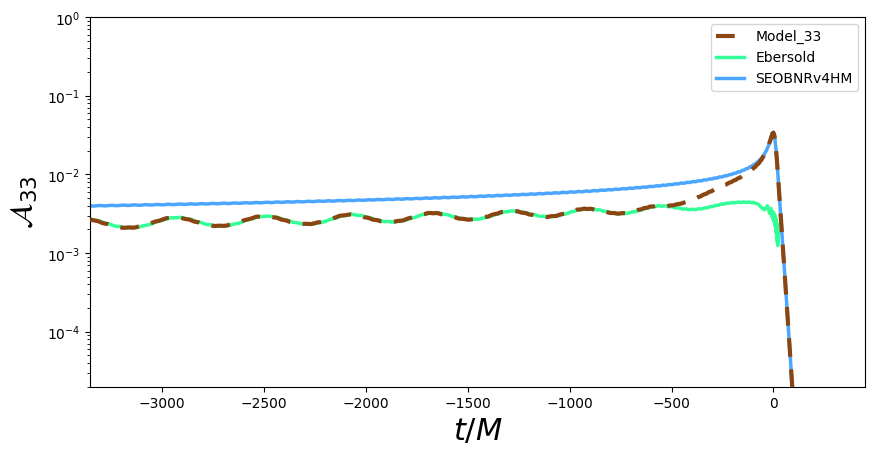

100%|█████████████████████████████████| 100106/100106 [00:45<00:00, 2211.13it/s]


Mode = (3,3) , Inclination =  20  degrees


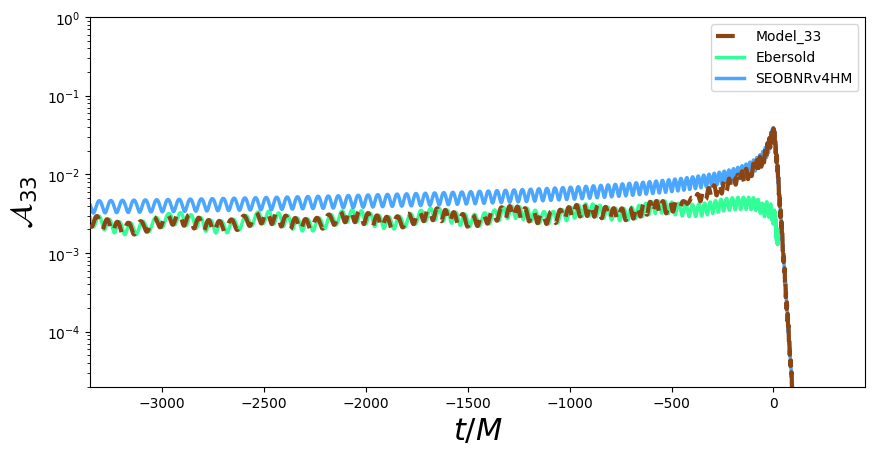

100%|█████████████████████████████████| 100106/100106 [00:45<00:00, 2201.96it/s]


Mode = (3,3) , Inclination =  30  degrees


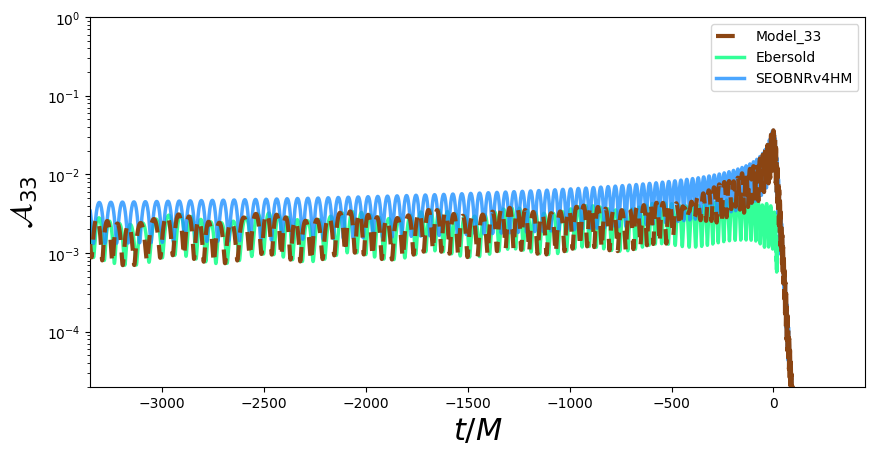

In [17]:
#MODEL33(10)
#MODEL33(20)
#MODEL33(30)

# MODEL $(l,m)=(4,4)$

In [27]:
def INSP_Eber(lp,mp,inc):
    mp=mp
    q=2
    eref=0.05
    e0=0.12
    eta=neu=nu=q/(1+q)**2
    xlow=0.045
    xref=0.075
    cl=lref=2.132
    G=c=d=1
    M=1
    M_SI=M*MSUN_SI
    D_SI=(10**(6))*PC_SI
    M2=M/(1+q)
    M1=M2*q
    Delta=math.sqrt(1-(4*neu))
    gamma=EulerGamma=0.577215664901
    %run GW_functions.ipynb
    mt=M
    m_sun=MSUN_SI
    conv=mt*MTSUN_SI
    
    def freq(u,mass):
        return math.pow(u,3.0/2.0)/(2*MTSUN_SI*mass*lal.PI/2)
    
    f_low=freq(xlow,mt)
    f_ref=freq(xref,mt)
    x=xlow
    v=math.sqrt(x)
    vref=math.sqrt(xref)
    xie=v**3
    xiref=vref**3
    e=eref*(xiref/xie)**(19/18)*epsilon(xie, eta)/epsilon(xiref, eta)

    
    hpVec_PN, hcVec_PN=get_td_waveform(approximant='EccentricTD',mass1=M1,
                                      mass2=M2,delta_t=1/2**20,f_lower=f_low,
                                      eccentricity=e0,distance=1)
    
    #inspired from PN-NR comp.ipynb
    tC_NR=0.01689910888671875
    tVec_PN_shifted=tC_NR+hpVec_PN.sample_times
    phase_EccTD = waveform.utils.phase_from_polarizations(hpVec_PN/((G_SI*M_SI/D_SI/C_SI/C_SI)), hcVec_PN/((G_SI*M_SI/D_SI/C_SI/C_SI)))

   
    tVec_PN_GM=tVec_PN_shifted/conv
    hpVec_PN_GM=hpVec_PN/((G_SI*M_SI/D_SI/C_SI/C_SI))
    hcVec_PN_GM=hcVec_PN/((G_SI*M_SI/D_SI/C_SI/C_SI))
    tC_NR=tC_NR/conv
    
    tVec_PN=tVec_PN_GM
    tC_NR=tC_NR
    
    xi_ref=xref**(3/2)
    x0=xlow
    xi0=x0**(3/2)
    v0=xi0**(1/3)
    l0=mean_anomaly(xi_ref,xi0,lref,eta,e0)
    theta=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN)**(-1/8)
    theta0=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN[0])**(-1/8)
    fVec=x_from_t(theta, theta0, e0, M, eta)
    
    xiVec=(np.pi*M*fVec)
    xVec=xiVec**(2/3)
    vVec=xiVec**(1/3)
    
    for i in range(0,len(xVec)):
        if xVec[i]>=0.1025:
            #print(i)
            break
    lst=100104
    
    plotIdx2=np.nonzero(fVec>=0)
    fVec=fVec[plotIdx2]
    xiVec=xiVec[plotIdx2]
    xVec=xVec[plotIdx2]
    vVec=vVec[plotIdx2]
    maxPNidx=len(xVec)
    
    j=0
    omega=[]
    phasePN = []
    hlm_real=[]
    hlm_imag=[]
    hlm_abs44=[]
    h44=[]
    h4_4=[]
    
    for i in tqdm(xVec):
        v=math.sqrt(i)
        v0=math.sqrt(x0)
        xie=v**3
        xi0=v0**3
        e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
        l=mean_anomaly(xie, xi0, l0, eta,e0)
        psi=phase_EccTD[j]
        j=j+1
        xi=l   #use xi for amplitude (xie is being used for v**3)
        x=i
        h=amplitude_44(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
        phasePN.append(mp*psi/2)
        hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
        hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        #hlm_real.append(hlm.real)
        #hlm_imag.append(hlm.imag)
        #hlm_abs33.append(abs(hlm))
        h44.append(hlm)
        h4_4.append(hl_m)
        
    
    sph44, sph4_4 = sph_harmonics(inc,lp)
    
    h = np.multiply(h44,sph44)+np.multiply(h4_4,sph4_4)
    hp=np.real(h)
    hc=np.imag(h)
    H=hp+1j*hc
    H=abs(H)
    tPN=tVec_PN[:maxPNidx]
    PNamp=H[:maxPNidx]
    lst = 100050
    #plt.ylim(ymax=1e0)
    #plt.ylim(ymin=2e-5)
    #plt.xlim(xmin=-3350)
    #plt.xlim(xmax=450)
    #plt.yscale('log')
    #plt.plot(tPN[:lst]-tPN[np.argmax(PNamp)] + 32,PNamp[:lst],linewidth = 1,color='black',linestyle='-')
    return tPN[:lst]-tPN[np.argmax(PNamp)] + 32,PNamp[:lst]

In [28]:
def MODEL44(angle):
    hfile = ['1364hyb_EccTD_xlow045_GM.h5'] #Hybrid
    l0=-0.181 #0.665
    x0=0.045
    e0=0.12 #0.142
    q=2 #3
    eta=q/(1+q)**2
    f0=20
    
    for i in range(0,len(hfile)):
        hyb_name=hfile[i][0:4]
        f=h5py.File(hfile[i],'r')
        data=f['l2_m2']
        tVec=real(data[0:,0])
        h22pVec=real(data[0:,1])
        h22cVec=real(data[0:,2])
        mode2polfac=4*(5/(64*np.pi))**(1/2)
        hpVec=h22pVec
        hcVec=h22cVec
        
        tVec=tVec - tVec[np.argmax(abs(hpVec+1j*hcVec))]
        M=40
        M1=q*M/(1+q)
        M2=M/(1+q)
        q0=q
        M_SI=M*MSUN_SI
        D_SI=(10**(6))*PC_SI
        tVec=tVec*M*MTSUN_SI
        hpVec=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac
        hcVec=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac
        
        tVec = tVec - tVec[np.argmax(abs(hpVec+1j*hcVec))]
        
        delta_t = delta_t_NR = np.abs(np.mean((np.diff(tVec))))
        
        fref = 0.075**(3/2) /MTSUN_SI/ PI/M
        fmin = 0.045**(3/2) /MTSUN_SI/ PI/M
        
        tEber, h22Eber = INSP_Eber(4,4,angle)
        
        sp,sc = get_td_waveform(approximant='SEOBNRv4HM', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin, inclination=angle, mode_array=[[4,4]])
        
        
        tEber=np.array(tEber)*(M*MTSUN_SI)
        #tEber=list(tEber)
        h22Eber=np.array(h22Eber)*(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac)
        #h22Eber=list(h22Eber)
        
        tshift = -tshift_Hinsp(q0,e0,l0)*M*MTSUN_SI
        tmin = max(tEber[0]-tshift, sp.sample_times[0])
        
        #Circular IMR
        sp_intrp = interp1d(sp.sample_times, sp, kind='cubic', fill_value='extrapolate')
        sc_intrp = interp1d(sc.sample_times, sc, kind='cubic', fill_value='extrapolate')
        tImr_intrp = np.arange(tmin, sp.sample_times[-1], delta_t)
        sp_intrp = sp_intrp(tImr_intrp)
        sc_intrp = sc_intrp(tImr_intrp)
        tImr = tImr_intrp
        hpImr = sp_intrp
        hcImr = sc_intrp
        h22Imr = hpImr + 1j*hcImr
        
        tshift = -tshift_Hinsp(q0,e0,l0)*M*MTSUN_SI
        
        #Interpolation Ebersold
        h22Eber_intrp = interp1d(tEber-tshift, h22Eber, kind='cubic', fill_value = 'extrapolate')
        tEber_intrp = np.arange(tmin, tEber[-1]-tshift, delta_t)
        h22Eber_intrp=h22Eber_intrp(tEber_intrp)
        arg = np.argmin(abs(tEber_intrp-tamp_Hinsp(eta,e0,l0)*M*MTSUN_SI))
        Idxjoin = arg
        
        t_amp = tamp_Hinsp(eta,e0,l0) - 500
        idxstr = np.argmin(abs(tEber_intrp-t_amp*M*MTSUN_SI))
        
        #Amplitude Model
        amp=[]
        count=0
        length=Idxjoin-idxstr
        
        for i in range(idxstr,Idxjoin):
            amp.append(((length-count)*h22Eber_intrp[i]+count*abs(h22Imr[i]))/length)
            count=count+1
            
        t_model=np.concatenate((tEber_intrp[0:Idxjoin],tImr[Idxjoin:len(tImr)]))
        h22amp=np.concatenate((abs(h22Eber_intrp[0:idxstr]),amp))
        h22amp_model=np.concatenate((h22amp,abs(h22Imr[Idxjoin:len(h22Imr)])))
        
        print('Mode = (4,4) , Inclination = ',angle,' degrees')
        #Plot
        plt.figure(figsize=(10,4.8))
        plt.plot(t_model/(M*MTSUN_SI),h22amp_model/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac), color = 'saddlebrown',alpha=1,dashes=(4.5,3),linewidth=3,linestyle='--',label='Model_44',zorder=3)
        plt.plot(tEber/(M*MTSUN_SI),h22Eber/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),linestyle='-',linewidth=2.5,color='springgreen',alpha=0.8,label='Ebersold',zorder=2)
        plt.plot(tImr/(M*MTSUN_SI),abs(h22Imr)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),linestyle='-',linewidth=2.5,color='dodgerblue',alpha=0.8,label='SEOBNRv4HM',zorder=2)
        
        plt.ylim(ymax=1e0)
        plt.ylim(ymin=2e-5)
        plt.xlim(xmin=-3350)
        plt.xlim(xmax=450)
        plt.ylabel(r'$\mathcal{A}_{44}$',fontsize=22,labelpad=5)
        plt.xlabel(r'$t/M$',fontsize=22)
        plt.yscale('log')
        plt.legend()
        
        
        

100%|█████████████████████████████████| 100106/100106 [00:31<00:00, 3131.16it/s]


Mode = (4,4) , Inclination =  10  degrees


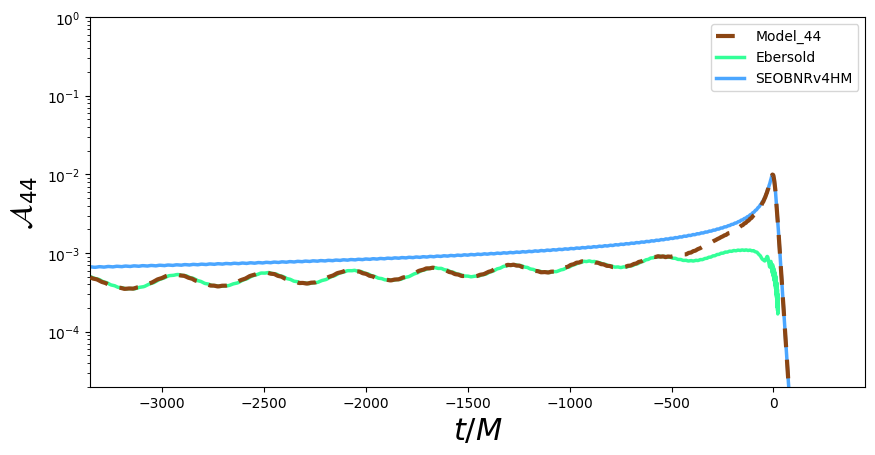

100%|█████████████████████████████████| 100106/100106 [00:32<00:00, 3102.75it/s]


Mode = (4,4) , Inclination =  20  degrees


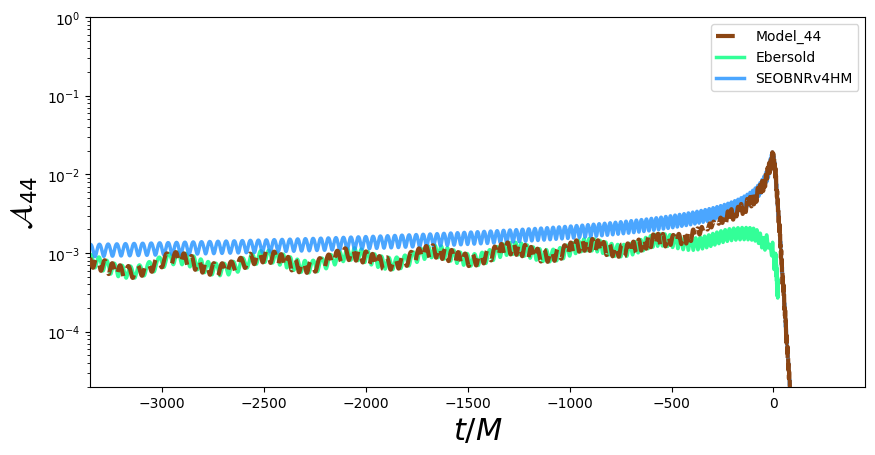

100%|█████████████████████████████████| 100106/100106 [00:32<00:00, 3114.19it/s]


Mode = (4,4) , Inclination =  30  degrees


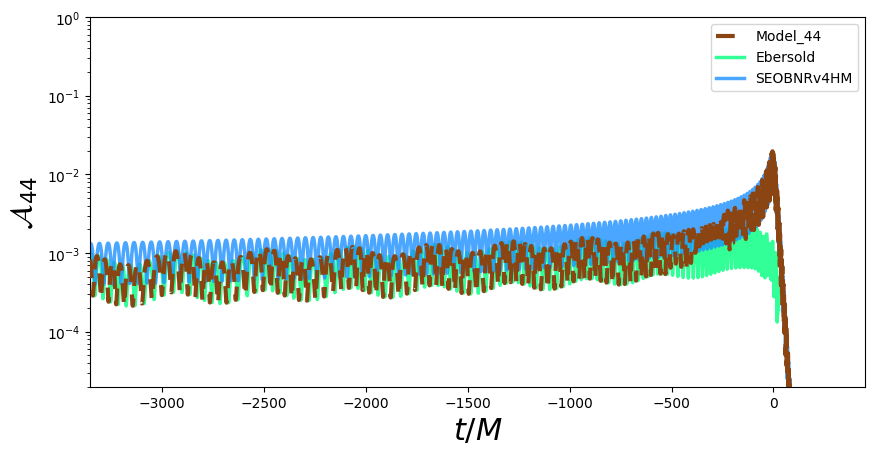

In [29]:
#MODEL44(10)
#MODEL44(20)
#MODEL44(30)

# MODEL $(l,m)=(5,5)$

In [30]:
def INSP_Eber(lp,mp,inc):
    mp=mp
    q=2
    eref=0.05
    e0=0.12
    eta=neu=nu=q/(1+q)**2
    xlow=0.045
    xref=0.075
    cl=lref=2.132
    G=c=d=1
    M=1
    M_SI=M*MSUN_SI
    D_SI=(10**(6))*PC_SI
    M2=M/(1+q)
    M1=M2*q
    Delta=math.sqrt(1-(4*neu))
    gamma=EulerGamma=0.577215664901
    %run GW_functions.ipynb
    mt=M
    m_sun=MSUN_SI
    conv=mt*MTSUN_SI
    
    def freq(u,mass):
        return math.pow(u,3.0/2.0)/(2*MTSUN_SI*mass*lal.PI/2)
    
    f_low=freq(xlow,mt)
    f_ref=freq(xref,mt)
    x=xlow
    v=math.sqrt(x)
    vref=math.sqrt(xref)
    xie=v**3
    xiref=vref**3
    e=eref*(xiref/xie)**(19/18)*epsilon(xie, eta)/epsilon(xiref, eta)

    
    hpVec_PN, hcVec_PN=get_td_waveform(approximant='EccentricTD',mass1=M1,
                                      mass2=M2,delta_t=1/2**20,f_lower=f_low,
                                      eccentricity=e0,distance=1)
    
    #inspired from PN-NR comp.ipynb
    tC_NR=0.01689910888671875
    tVec_PN_shifted=tC_NR+hpVec_PN.sample_times
    phase_EccTD = waveform.utils.phase_from_polarizations(hpVec_PN/((G_SI*M_SI/D_SI/C_SI/C_SI)), hcVec_PN/((G_SI*M_SI/D_SI/C_SI/C_SI)))

   
    tVec_PN_GM=tVec_PN_shifted/conv
    hpVec_PN_GM=hpVec_PN/((G_SI*M_SI/D_SI/C_SI/C_SI))
    hcVec_PN_GM=hcVec_PN/((G_SI*M_SI/D_SI/C_SI/C_SI))
    tC_NR=tC_NR/conv
    
    tVec_PN=tVec_PN_GM
    tC_NR=tC_NR
    
    xi_ref=xref**(3/2)
    x0=xlow
    xi0=x0**(3/2)
    v0=xi0**(1/3)
    l0=mean_anomaly(xi_ref,xi0,lref,eta,e0)
    theta=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN)**(-1/8)
    theta0=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN[0])**(-1/8)
    fVec=x_from_t(theta, theta0, e0, M, eta)
    
    xiVec=(np.pi*M*fVec)
    xVec=xiVec**(2/3)
    vVec=xiVec**(1/3)
    
    for i in range(0,len(xVec)):
        if xVec[i]>=0.1025:
            #print(i)
            break
    lst=100104
    
    plotIdx2=np.nonzero(fVec>=0)
    fVec=fVec[plotIdx2]
    xiVec=xiVec[plotIdx2]
    xVec=xVec[plotIdx2]
    vVec=vVec[plotIdx2]
    maxPNidx=len(xVec)
    
    j=0
    omega=[]
    phasePN = []
    hlm_real=[]
    hlm_imag=[]
    hlm_abs55=[]
    h55=[]
    h5_5=[]
    
    for i in tqdm(xVec):
        v=math.sqrt(i)
        v0=math.sqrt(x0)
        xie=v**3
        xi0=v0**3
        e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
        l=mean_anomaly(xie, xi0, l0, eta,e0)
        psi=phase_EccTD[j]
        j=j+1
        xi=l   #use xi for amplitude (xie is being used for v**3)
        x=i
        h=amplitude_55(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
        phasePN.append(mp*psi/2)
        hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
        hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        #hlm_real.append(hlm.real)
        #hlm_imag.append(hlm.imag)
        #hlm_abs33.append(abs(hlm))
        h55.append(hlm)
        h5_5.append(hl_m)
     
    sph55, sph5_5 = sph_harmonics(inc,lp)
    
    h = np.multiply(h55,sph55)+np.multiply(h5_5,sph5_5)
    hp=np.real(h)
    hc=np.imag(h)
    H=hp+1j*hc
    H=abs(H)
    tPN=tVec_PN[:maxPNidx]
    PNamp=H[:maxPNidx]
    lst = 100050
    #plt.ylim(ymax=1e0)
    #plt.ylim(ymin=2e-5)
    #plt.xlim(xmin=-3350)
    #plt.xlim(xmax=450)
    #plt.yscale('log')
    #plt.plot(tPN[:lst]-tPN[np.argmax(PNamp)] + 32,PNamp[:lst],linewidth = 1,color='black',linestyle='-')
    return tPN[:lst]-tPN[np.argmax(PNamp)] + 32,PNamp[:lst]

In [31]:
def MODEL55(angle):
    hfile = ['1364hyb_EccTD_xlow045_GM.h5'] #Hybrid
    l0=-0.181 #0.665
    x0=0.045
    e0=0.12 #0.142
    q=2 #3
    eta=q/(1+q)**2
    f0=20
    
    for i in range(0,len(hfile)):
        hyb_name=hfile[i][0:4]
        f=h5py.File(hfile[i],'r')
        data=f['l2_m2']
        tVec=real(data[0:,0])
        h22pVec=real(data[0:,1])
        h22cVec=real(data[0:,2])
        mode2polfac=4*(5/(64*np.pi))**(1/2)
        hpVec=h22pVec
        hcVec=h22cVec
        
        tVec=tVec - tVec[np.argmax(abs(hpVec+1j*hcVec))]
        M=40
        M1=q*M/(1+q)
        M2=M/(1+q)
        q0=q
        M_SI=M*MSUN_SI
        D_SI=(10**(6))*PC_SI
        tVec=tVec*M*MTSUN_SI
        hpVec=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac
        hcVec=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac
        
        tVec = tVec - tVec[np.argmax(abs(hpVec+1j*hcVec))]
        
        delta_t = delta_t_NR = np.abs(np.mean((np.diff(tVec))))
        
        fref = 0.075**(3/2) /MTSUN_SI/ PI/M
        fmin = 0.045**(3/2) /MTSUN_SI/ PI/M
        
        tEber, h22Eber = INSP_Eber(5,5,angle)
        
        sp,sc = get_td_waveform(approximant='SEOBNRv4HM', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin, inclination=angle, mode_array=[[5,5]])
        
        
        tEber=np.array(tEber)*(M*MTSUN_SI)
        #tEber=list(tEber)
        h22Eber=np.array(h22Eber)*(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac)
        #h22Eber=list(h22Eber)
        
        tshift = -tshift_Hinsp(q0,e0,l0)*M*MTSUN_SI
        tmin = max(tEber[0]-tshift, sp.sample_times[0])
        
        #Circular IMR
        sp_intrp = interp1d(sp.sample_times, sp, kind='cubic', fill_value='extrapolate')
        sc_intrp = interp1d(sc.sample_times, sc, kind='cubic', fill_value='extrapolate')
        tImr_intrp = np.arange(tmin, sp.sample_times[-1], delta_t)
        sp_intrp = sp_intrp(tImr_intrp)
        sc_intrp = sc_intrp(tImr_intrp)
        tImr = tImr_intrp
        hpImr = sp_intrp
        hcImr = sc_intrp
        h22Imr = hpImr + 1j*hcImr
        
        tshift = -tshift_Hinsp(q0,e0,l0)*M*MTSUN_SI
        
        #Interpolation Ebersold
        h22Eber_intrp = interp1d(tEber-tshift, h22Eber, kind='cubic', fill_value = 'extrapolate')
        tEber_intrp = np.arange(tmin, tEber[-1]-tshift, delta_t)
        h22Eber_intrp=h22Eber_intrp(tEber_intrp)
        arg = np.argmin(abs(tEber_intrp-tamp_Hinsp(eta,e0,l0)*M*MTSUN_SI))
        Idxjoin = arg
        
        t_amp = tamp_Hinsp(eta,e0,l0) - 500
        idxstr = np.argmin(abs(tEber_intrp-t_amp*M*MTSUN_SI))
        
        #Amplitude Model
        amp=[]
        count=0
        length=Idxjoin-idxstr
        
        for i in range(idxstr,Idxjoin):
            amp.append(((length-count)*h22Eber_intrp[i]+count*abs(h22Imr[i]))/length)
            count=count+1
            
        t_model=np.concatenate((tEber_intrp[0:Idxjoin],tImr[Idxjoin:len(tImr)]))
        h22amp=np.concatenate((abs(h22Eber_intrp[0:idxstr]),amp))
        h22amp_model=np.concatenate((h22amp,abs(h22Imr[Idxjoin:len(h22Imr)])))
        
        print('Mode = (5,5) , Inclination = ',angle,' degrees')
        #Plot
        plt.figure(figsize=(10,4.8))
        plt.plot(t_model/(M*MTSUN_SI),h22amp_model/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac), color = 'saddlebrown',alpha=1,dashes=(4.5,3),linewidth=3,linestyle='--',label='Model_55',zorder=3)
        plt.plot(tEber/(M*MTSUN_SI),h22Eber/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),linestyle='-',linewidth=2.5,color='springgreen',alpha=0.8,label='Ebersold',zorder=2)
        plt.plot(tImr/(M*MTSUN_SI),abs(h22Imr)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),linestyle='-',linewidth=2.5,color='dodgerblue',alpha=0.8,label='SEOBNRv4HM',zorder=2)
        
        plt.ylim(ymax=1e0)
        plt.ylim(ymin=2e-7)
        plt.xlim(xmin=-3350)
        plt.xlim(xmax=450)
        plt.ylabel(r'$\mathcal{A}_{55}$',fontsize=22,labelpad=5)
        plt.xlabel(r'$t/M$',fontsize=22)
        plt.yscale('log')
        plt.legend()
        
        
        

100%|█████████████████████████████████| 100106/100106 [00:35<00:00, 2852.21it/s]


Mode = (5,5) , Inclination =  10  degrees


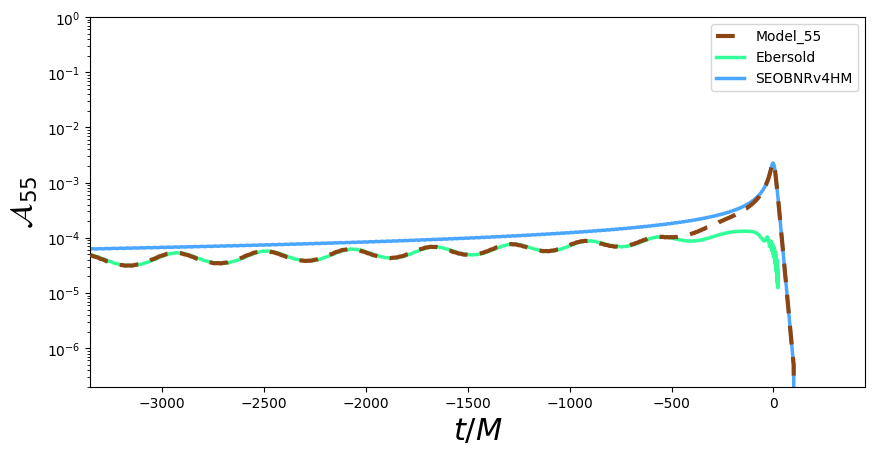

100%|█████████████████████████████████| 100106/100106 [00:32<00:00, 3040.01it/s]


Mode = (5,5) , Inclination =  20  degrees


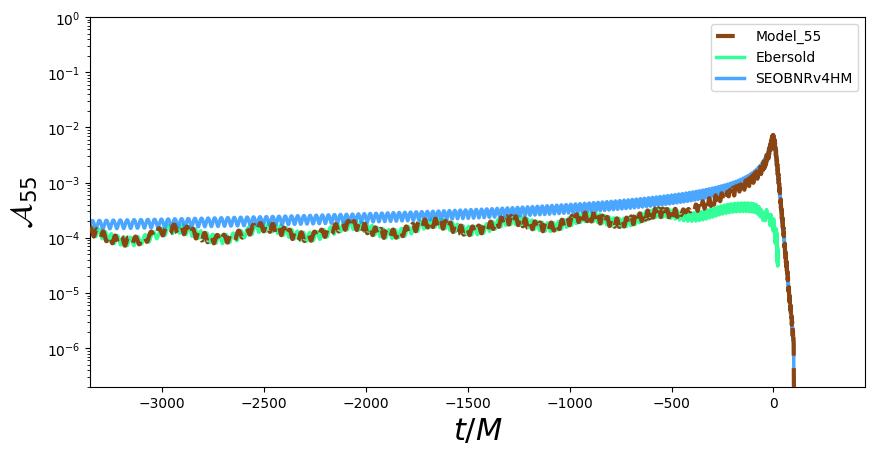

100%|█████████████████████████████████| 100106/100106 [00:37<00:00, 2670.55it/s]


Mode = (5,5) , Inclination =  30  degrees


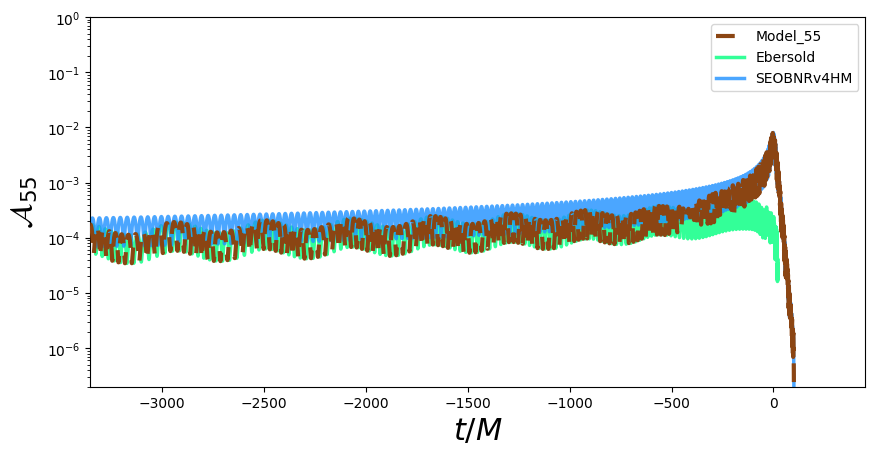

In [32]:
#MODEL55(10)
#MODEL55(20)
#MODEL55(30)